# Coursework for MRI reconstruction (Autumn 2019) Group 10

Best reconstruction results : https://drive.google.com/drive/folders/1OGyvaKbVwCAailivJueuA3n5J_D18vbq?usp=sharing

  # Implmentation
  
Below shows the source code for the neural network that was implemented. Within the code, them performance anaylisis mechanisms were described when neccessary. Some of the features described in the implementation refer to the report, where in places it is described in more detail.
  

In [1]:
#ALL IMPORTS
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
#cuda
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #'cpu'



The Unet model below created by MIT, and was used in this assignment as a platform to build the neural network. https://github.com/facebookresearch/fastMRI.git

In [2]:
#UNET MODEL

class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [3]:
######This function was amended to allow for changes in the batch size.######

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
    ######### AMENDMENT #########
    
    #convert complex numbers to abs to ensure it is useable.
    #Cropping was completed here to allow for images to be 
    #compared effectively and can be placed over eachother 320 by 320 square
    
    volume_image_abs = T.complex_abs(img_gt) 
    cropped_gt = T.center_crop(volume_image_abs, [320, 320])
    cropped_gt = cropped_gt
        
    volume_image_abs = T.complex_abs(img_und) 
    cropped_img_und = T.center_crop(volume_image_abs, [320, 320])
    cropped_img_und = cropped_img_und
        
    return cropped_gt,cropped_img_und, norm


In [4]:
#pre-defined ultily functions used in creating the neural net

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')


class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)
    
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]

    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []

        which_data_path = data_path[i]

        for fname in sorted(os.listdir(which_data_path)):

            subject_data_path = os.path.join(which_data_path, fname)

            if not os.path.isfile(subject_data_path): continue 

            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]

            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]

    return data_list  
   
    
from skimage.measure import compare_ssim  
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )  


def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [ ]:
Below is where the model is created. #### Describe each parameter.

In [5]:

torch.manual_seed(42)

# Create a model
model = UnetModel(
    in_chans = 1,
    out_chans = 1,
    chans = 32,
    num_pool_layers = 4,
    drop_prob = 0 ).to(device) 


In [ ]:
The data set is shuffled

In [6]:
#Set initial path for the fullset of training data
file_path = '/data/local/NC2019MRI/train'

# Shuffle sets, and split train_index into train and validation 80:20 respectively. 
#this was chosen as a reasonable split for the data set size. Any less the validation results 
#may prove unrepresentative, whereas any more would deprive the model of useful information to train with

#Shuffling was done to ensure higher probabilty that the neural model will be trained in such as way,
# that it will generalize over unseen data sets.
numfiles_all = len(os.listdir(file_path))
print (numfiles_all)
indx = np.arange(numfiles_all)
np.random.shuffle(indx)

split_80_20 = 0.8 * numfiles_all
split_80_20 = int(split_80_20)
print(split_80_20)

#############
np.random.seed(42)

train_inx = indx[:split_80_20]
val_inx = indx[split_80_20:]

#varify split and shuffling
print("train_inx",train_inx)
print("val_inx",val_inx)


70
56
train_inx [49  1  7 53  9 35 37 51 14  0 29 41 58 30 59 10 61  8 13 65 15  6 16 39
 64 24 62 50 69 55 18 21 57 45 40 28 63 26 43 60  4 54 48 44 33 31 20 32
 23 47 11 27 68 19 42 34]
val_inx [67 38 52 56  3 25 12 46 22 66 36  2  5 17]


In [7]:

    #set list for storage of both train and validation data
    train_data_list = {}
    train_data_list['val']= [0] * len(val_inx)
    train_data_list['train'] = [0] * len(train_inx)
    count = 0  
    
    #read in and store the h5 files from the data set in the coorect order as in the shuffed indexes
    #for each set
    for fname in sorted(os.listdir(file_path)): 
        subject_path = os.path.join(file_path, fname)
        with h5py.File(subject_path,  "r") as hf:
             total_num_slices = hf['kspace'].shape[0]

        #for train data      
        for i in range(len(train_inx)):
            if (train_inx[i] == count):
                train_data_list['train'][i] = (file_path+ "/" +fname, fname, total_num_slices)  
                break
        #for validation data   
        for k in range(len(val_inx)):
            if (val_inx[k] == count):
                train_data_list['val'][k] = (file_path+ "/"+ fname, fname, total_num_slices)
                break
        count = count +1

            
    train_data_final ={}         
    train_data_final['train'] = []  
    train_data_final['val'] = []  
    
    #The previous function only shuffled the H5files but did not include the slices. The slices are included
    #in the correct order here for both train and validation
    for i in range (len(train_data_list['train'])):
        for slice in range (5,train_data_list['train'][i][2]):
            train_data_final['train'].append((train_data_list['train'][i][1], train_data_list['train'][i][0], (slice)))
        

    for i in range (len(train_data_list['val'])):
        for slice in range (5,train_data_list['val'][i][2]):
            train_data_final['val'].append((train_data_list['val'][i][1], train_data_list['val'][i][0], slice))

            

In [8]:
#Varification of shuffled data lists for loading
print("VALIDATION SET")
valcount = 0
for i in range (len(train_data_final['val'])):
    print(" count : ",valcount,"  ", train_data_final['val'][i])
    valcount = valcount + 1
    
print("")
print("")
print("")
print("")

train_count = 0    
print("TRAIN SET")
for i in range (len(train_data_final['train'])):
    print(" count : ",train_count,"  ", train_data_final['train'][i])
    train_count = train_count + 1


VALIDATION SET
 count :  0    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 5)
 count :  1    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 6)
 count :  2    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 7)
 count :  3    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 8)
 count :  4    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 9)
 count :  5    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 10)
 count :  6    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 11)
 count :  7    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 12)
 count :  8    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 13)
 count :  9    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 14)
 count :  10    ('file1000759.h5', '/data/local/NC2019MRI/train/file1000759.h5', 15)
 count :  11    ('file1000759.h5', '/data/local/NC2019MRI/train/f

 count :  268    ('file1000243.h5', '/data/local/NC2019MRI/train/file1000243.h5', 28)
 count :  269    ('file1000243.h5', '/data/local/NC2019MRI/train/file1000243.h5', 29)
 count :  270    ('file1000243.h5', '/data/local/NC2019MRI/train/file1000243.h5', 30)
 count :  271    ('file1000243.h5', '/data/local/NC2019MRI/train/file1000243.h5', 31)
 count :  272    ('file1000243.h5', '/data/local/NC2019MRI/train/file1000243.h5', 32)
 count :  273    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 5)
 count :  274    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 6)
 count :  275    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 7)
 count :  276    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 8)
 count :  277    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 9)
 count :  278    ('file1000758.h5', '/data/local/NC2019MRI/train/file1000758.h5', 10)
 count :  279    ('file1000758.h5', '/data/local/NC2019MRI/

 count :  649    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 20)
 count :  650    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 21)
 count :  651    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 22)
 count :  652    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 23)
 count :  653    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 24)
 count :  654    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 25)
 count :  655    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 26)
 count :  656    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 27)
 count :  657    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 28)
 count :  658    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 29)
 count :  659    ('file1000041.h5', '/data/local/NC2019MRI/train/file1000041.h5', 30)
 count :  660    ('file1000041.h5', '/data/local/NC201

 count :  870    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 30)
 count :  871    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 31)
 count :  872    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 32)
 count :  873    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 33)
 count :  874    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 34)
 count :  875    ('file1000810.h5', '/data/local/NC2019MRI/train/file1000810.h5', 35)
 count :  876    ('file1000593.h5', '/data/local/NC2019MRI/train/file1000593.h5', 5)
 count :  877    ('file1000593.h5', '/data/local/NC2019MRI/train/file1000593.h5', 6)
 count :  878    ('file1000593.h5', '/data/local/NC2019MRI/train/file1000593.h5', 7)
 count :  879    ('file1000593.h5', '/data/local/NC2019MRI/train/file1000593.h5', 8)
 count :  880    ('file1000593.h5', '/data/local/NC2019MRI/train/file1000593.h5', 9)
 count :  881    ('file1000593.h5', '/data/local/NC2019MRI/

 count :  1669    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 23)
 count :  1670    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 24)
 count :  1671    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 25)
 count :  1672    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 26)
 count :  1673    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 27)
 count :  1674    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 28)
 count :  1675    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 29)
 count :  1676    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 30)
 count :  1677    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 31)
 count :  1678    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 32)
 count :  1679    ('file1000389.h5', '/data/local/NC2019MRI/train/file1000389.h5', 33)
 count :  1680    ('file1000389.h5', '/data

In [9]:
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.


In [1]:
#loads_train_data
if __name__ == '__main__':
    
    #This is where the undersampling parameters are set. In this ###################
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    
    #More works the better.....############
    num_workers = 12 
    
    
    #Train batch size set to 5 optimum
    train_dataset = MRIDataset(train_data_final['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=5, num_workers=num_workers) 
    
    # Validation: turned off in final models, used in experimetaly 
    validation_dataset = MRIDataset(train_data_final['val'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=5, num_workers=num_workers)  

NameError: name 'MRIDataset' is not defined

Here is where the neural network model was trained. The parameters and their values present below was that of the best overall results, however is is noteworthy that validation was turned off in final models.

In [11]:
#set training
%matplotlib inline 

# set learning rate
lr = 1e-3

#set number of epoches, i.e., number of times we iterate through the training set
epoches = 50

#We use mean square error (MSELoss) a base parameter.
loss_fn = nn.MSELoss(reduction='mean').to(device)

# Optimisers a variable parameter that was experimented with
optimiser = torch.optim.RMSprop(model.parameters(), lr=lr)


#Lists for plotting val/train SSIM/Loss/prEpoch
train_av_epoch_ssim_list = []
train_av_epoch_loss_list = []

val_av_epoch_ssim_list = []
val_av_epoch_loss_list = []

epoch_count = 0

#Model training
for epoch in range(epoches):
    
    # Set the model to training mode.
    model.train()
    
    #For generating average calculation for each epoch of SSIM and Loss
    train_total_loss = 0
    train_total_ssim = 0
    train_iterations= 0
    
    val_total_loss = 0
    val_total_ssim = 0
    val_iterations= 0
    
    #Training
    for data in train_loader:

        #The cropped ground truth target and the undersampled input are unloaded
        #here for use in generation of our prediction.
        img_gt, img_und, _ = data
        
        #pushed to the GPU
        img_gt = img_gt.to(device) 
        img_und.to(device) 
        
        #zeros the gradient #######
        optimiser.zero_grad()
        
        #Reconstruction/prediction from undersampled data
        y_pred = model(img_und.to(device))
        
        #In order for to calculate SSIM and to visualise the images,
        #the data must be taken back off the GPU, and converted to a numpy array
        #from a tensor object.
        A = img_und.squeeze().squeeze().numpy()[0:1,:,:]
        B = y_pred.squeeze().squeeze().squeeze(0).detach().cpu()
        B = y_pred.squeeze().data.cpu().numpy()
        B = B[0:1, :, :]
        C = img_gt.squeeze().squeeze().squeeze(0).cpu().numpy()[0:1,:,:]
        
    

        #Visualise results. Every 10 iterations all three data set images
        #are displayed for visual comparision. This is a useful tool for 
        #watching the progress of the training, and to identify any potential errors
        #at an early stage. This is because a percieved good SSIM value and low loss
        #does not neccessarily translate to an accurate image from practice.
        
        #Concatenates all the data
        all_imgs = np.concatenate([A,B,C], axis=0)
        
        # 0 = UNDERSAMPLED. 1 = PREDICTION. 2 = GROUND_TRUTH
        #if train_iterations % 10 == 1:
            #show_slices(all_imgs, [0,1,2], cmap='gray')
            #plt.pause(1)

        
        #calculate the loss from training data
        loss = loss_fn(img_gt.to(device), y_pred)
        loss.backward() 
        optimiser.step()
        
        #calculate total loss for epoch to generate average loss
        train_total_loss = train_total_loss + loss.item()
        
        # calculate total ssim value for epoch to generate average ssim
        ssim_value = ssim(C,B)
        train_total_ssim = train_total_ssim + ssim_value
     

        #count
        train_iterations = train_iterations +1
        
    #Calculate average train SSIM value and Loss values per epoch    
    train_av_ssim = train_total_ssim/train_iterations
    train_av_loss = train_total_loss/train_iterations
    
    train_av_epoch_ssim_list.append(train_av_ssim)
    train_av_epoch_loss_list.append(train_av_loss)
    
    
    #Validation: After each epoch the validation is conducted on the model on the validation set. 
    #In the final models all validation is turned off, and the full training data set was used for reasons 
    #discussed in experiements section.
    
    
    #Set to no grad, as back propogation is not requried in evalution/validation of model #############
    with torch.no_grad():
        
        #Set to evaluation mode. This is because it is important the model does not
        #see this data, as it would invalidate its purpose. Described in report in more detail.
        model.eval()
        for data in validation_loader:

            #from data loader
            img_gt, img_und, _ = data
            
            #Reconstruction/prediction from undersampled data
            img_gt = img_gt.to(device) 
            img_und.to(device) 
            optimiser.zero_grad()
            y_pred = model(img_und.to(device))
            
            #As in training step
            A = img_und.squeeze().squeeze().numpy()[0:1,:,:]
            B = y_pred.squeeze().squeeze().squeeze(0).detach().cpu()
            B = y_pred.squeeze().data.cpu().numpy()
            B = B[0:1, :, :]
            C = img_gt.squeeze().squeeze().squeeze(0).cpu().numpy()[0:1,:,:]
            
            #calculate the loss from validation data
            val_loss = loss_fn(img_gt.to(device), y_pred)
            optimiser.step()
            
            #calculate total loss for epoch to generate average loss
            val_total_loss = val_total_loss + loss.item()
        
            #calculate total ssim value for epoch to generate average ssim
            ssim_value = ssim(C,B)
            val_total_ssim = val_total_ssim + ssim_value
            
            #count
            val_iterations = val_iterations + 1
    
        #Calculate average validation SSIM value and Loss values per epoch
        val_av_ssim = val_total_ssim/val_iterations
        val_av_loss = val_total_loss/val_iterations
    
        #Store in list for graphing
        val_av_epoch_ssim_list.append(val_av_ssim)
        val_av_epoch_loss_list.append(val_av_loss)
    
    #For visualizing progress
    epoch_count = epoch_count + 1
    print("epoch_count ", epoch_count)

    #Varification of lists
print("epoch: ", epoch_count,"train_av_epoch_ssim_list :", train_av_epoch_ssim_list)
print("epoch: ", epoch_count,"train_av_epoch_loss_list :", train_av_epoch_loss_list)
print("epoch: ", epoch_count,"val_av_epoch_ssim_list :", val_av_epoch_ssim_list)
print("epoch: ", epoch_count,"val_av_epoch_loss_list :", val_av_epoch_loss_list)


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


epoch_count  1
epoch_count  2
epoch_count  3
epoch_count  4
epoch_count  5
epoch_count  6
epoch_count  7
epoch_count  8
epoch_count  9
epoch_count  10
epoch_count  11
epoch_count  12
epoch_count  13
epoch_count  14
epoch_count  15
epoch_count  16
epoch_count  17
epoch_count  18
epoch_count  19
epoch_count  20
epoch_count  21
epoch_count  22
epoch_count  23
epoch_count  24
epoch_count  25
epoch_count  26
epoch_count  27
epoch_count  28
epoch_count  29
epoch_count  30
epoch_count  31
epoch_count  32
epoch_count  33
epoch_count  34
epoch_count  35
epoch_count  36
epoch_count  37
epoch_count  38
epoch_count  39
epoch_count  40
epoch_count  41
epoch_count  42
epoch_count  43
epoch_count  44
epoch_count  45
epoch_count  46
epoch_count  47
epoch_count  48
epoch_count  49
epoch_count  50
epoch:  50 train_av_epoch_ssim_list : [0.3694150763168224, 0.4301532457878034, 0.4316432172046078, 0.4499425990317241, 0.45566325535209234, 0.4607403485000777, 0.4578840549126962, 0.4593341770015144, 0.4732289

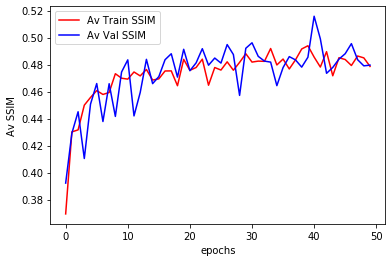

In [12]:
#VALIDATION VS TRAINING SSIM COMPARISON
plt.plot(range(len(train_av_epoch_ssim_list)), train_av_epoch_ssim_list,'r', label = "Av Train SSIM")
plt.plot(range(len(val_av_epoch_ssim_list)), val_av_epoch_ssim_list,'b', label = "Av Val SSIM")
plt.xlabel("epochs")
plt.ylabel("Av SSIM")
plt.legend()
plt.show()

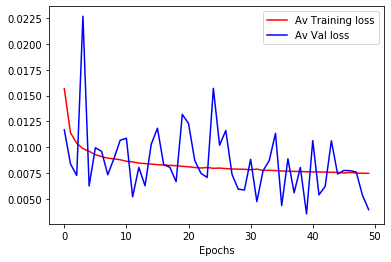

In [13]:
#VALIDATION VS TRAINING LOSS COMPARISON
plt.plot(range(len(train_av_epoch_loss_list)), train_av_epoch_loss_list,'r', label = "Av Training loss")
plt.plot(range(len(val_av_epoch_loss_list)), val_av_epoch_loss_list,'b', label = "Av Val loss")
plt.xlabel("Epochs")

plt.legend()
plt.show()

In [14]:
torch.save(model,"unet_model_save_50ep_sgd_le1_b5_L1.pkl")

/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UnetModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
#Generates averages for entire model as an approximate measure for

#x = train_av_epoch_loss_list
#x = val_av_epoch_loss_list
#x = train_av_epoch_ssim_list
x = val_av_epoch_ssim_list

total = 0
for i in range(len(x)):
    total = total +x[i]
    av = total/(len(x))
print(av)


0.47352255582969993


# Introduction

Biological Matter possess natural magnetic properties which can be mainipulated using a combination of magnetic disruptions and radio waves to produce KData [1]. 

KData in itself is not useful for visualising biological features, however when an inverse discrete fourier transform (DFT) is applied to the data, the data can be visualized.
KData contains complex numbers, therefore it must be preprocessed before visualization can occur (complex numbers made absolute). KData is held within 3 dimensions and is comprised of voxels. Each voxel contains a partition of the total kdata.

A common problem for producing accurate Kdata is the long acquisition time, which converts to higher financial costs and inefficiency in healthcare. By using a low acquisition time, the end result is less accurate. However by applying a neural network model, the image can be accurately predicted [2].

In this task, two sets of data were provided, each containing kdata.h5 files. Each H5 file contains multiple slices, which are stacked to form a 3D object.  In the test set, there were 30 low acquisition(low accuracy) H5 files, and in the training set were 70 h5 files each contain high acquisition (high accuracy). 
The original H5 files of the training set were used as the ground truth, and acted as the control of the experiment and the target output in the neural network designed.Two secondary data sets were created from undersampling the original training data, one 8-fold(high undersampled, and inaccurate), and one 4-fold(less undersampled).

The undersampled was created by applying ‘masks’ to the original ground truth data, which essential removed some Kdata information, and in doing so mimicked a low acquisition data MRI scan.
The aim of the experiment was to generate 2 neural network models using both of these undersampled sets with original target set, which can accurately convert low acquisition images to a more accurate representation, resembling that of the original ground truth set. 




# Design


## Data set

Training data is used to train our model and determined the parameters of the model in order to achieve the best results. But during the training process, when the bias of the data set is too high, it will cause the model we trained produce overfitting.  

Due to the role of fitting the high-frequency noise elements, large amplitudes appear when higher-order sessions accompany. In this case, the high order polynomial courses will generate the corresponding high-frequency fluctuations required [3].


This leads to the large deviations we see between the sampled points. This is known as overfitting which is a constant dilemma when working with the noisy datasets or a complex model. A model that overfits its training data tends to be able to generalise to unseen data and is not helpful in the process of machine learning.

To solve this problem, validatation of the data is required to ensure that the model we perceive is the optimal one. In our design, we divide the training data set into 80% training data and 20% validation data. After training the model with training data, we use the validation data set to test all models and then select the model with the least error rate. After formulating the optimal model, we then use the test data set to test the generalized ability of the trained model.

## SSIM

SSIM is an index used to measure images similarity. With the use of this, we use the images received after training to compare with ground truth. SSIM measures the quality of the results from the aspects of image brightness, contrast and structure [4]. The larger the value is, the closer the result is to ground truth, which means the model is better.


## Model¶

First and foremost, a literary search was conducted in order to identify the best platform to build upon. Two models were of interest, UNET and GAN.


### Gan  {###reduce, condense, much smaller, consise}

GAN is a base model for the neural network. It is composed of a generator and a discriminator. The purpose of the generator is to generate fake targets in an attempt to completely deceive the discriminator. The discriminator improves its discrimination ability by learning the true target and the false target, so as not to let the false target fool itself. The two evolved and played against each other. Finally, the evolution stopped until the false target was very similar to the true target. However, it may generate some unpredicted results due to its unsupervised scheme and still get a high score [5].

## U-net was another model of interest

![unet.png](./unet.png)
In 2015, Olaf Ronneberger and others proposed a U-net network structure. The U-net network is a semantic segmentation network based on FCN, which is suitable for medical image segmentation [6].

The entire U-Net network structure is shown in the figure above, similar to a large U letter: first convolution + Pooling down-sampling; then deconvolution for up-sampling, low-level feature map before the crop, and fusion; then up-sampling again. This process is repeated until a feature map is generated with an output of 388x388x2, and then finally obtain the output segment map through soft-max. Overall, it is very similar to the FCN idea. Unet's original intention is to solve the problems of biomedical images. This gave rise to it being widely used in various directions of semantic segmentation, such as satellite image segmentation and industrial defect detection [7].


### Conclusion 
###### Advantages of U-net
• Support for training models with a small amount of data 

• Get higher segmentation accuracy by classifying each pixel 

• Fast segmentation with trained models 

From the findings from literature, it was decided that UNET offered the best attributes for this specific assignment.Unet has been more established, and has yielded promising results. Furthermore, U-net has a fast processing speed and a higher segmentation accuracy, and has shown to yield good results with little data, which isn this case are valuable attributes.


Once unet was decided upon, the parameters were tested in order to identify their optimums, in doing so miniminizing loss values, and a maximizing SSIM values. This was conducted through a combination of literary search, and trial and error


## Batch Size 

It was reasoned an optuimum batch size for the model would be a reasonable starting point, as it would influence the speed of running further tests.

Batch size is the number of samples selected for a single training session [8]. Its size affects the degree and speed of optimization of the model. At the same time, it directly affects the GPU memory usage. When chose the best batch size, it can improve memory utilization through parallelization by enabling the GPU to run at full capacity to improve training speed. 

Also, the number of iterations of a single epoch is reduced and the adjustment of parameters is slow, which more epochs are required to achieve the same recognition accuracy.

Most importantly, the optimimum batch size for a particular model will improve the gradient descent.







# Optimizer and learning rate

The performance of the optimiser is highly dependent on the learning rate provided, and they do not all neccesarily have the same optimum learning rate value. Therefore each optimisation function was tested with and array of learning  rate values from 1e^-1 to 1e^-4.


# Optimizers tested
The main purpose of training a neural network is to find suitable parameters and obtain minimal loss values. The process of solving this problem is called optimization. The algorithm used to solve this problem is called optimizer. Among various optimizers, we choose three of them as listed below into our account. These three are basicly improved versions based on other optimizers, thus can achieve better result.  

### Stochastic Gradient Descent (SGD)

Stochastic gradient descent (SGD) computes the gradient of the cost function with respect to the parameters $\theta$. What's more, the whole training dataset delivers a parameter update for each training example $x^{(i)}$ and label $y^{(i)}$. It prevents redundant computations for large datasets and usually processes relatively fast. However, since SGD conducts frequent updates with high variance, it can cause the objective function to fluctuate rigorously. Also, when facing local optimal where curves are much more steeply in one dimension than in another. SGD oscillates across the area and makes slow progress [9]. This leads to RMSprop.  
$$\theta = \theta - \eta \cdot \nabla_\theta J ( \theta ; x^{(i)} ; y^{(i)} ) $$

### RMSprop

For the learning rate of models, traditional optimizer either set the learning rate to a constant or adjust the learning rate based training results. All ignore the potential of the learning rate.

We can consider RMSprop as an adaptation of the rprop algorithm to learning with mini-batch. This was the original motivation for developing the algorithm. It performs low learning rates on parameters related to frequently occurring features and performs high learning rates to obtain parameters related to less commonly used features [10]. Therefore, it is very suitable for dealing with sparse data. In this way, it can greatly improve the robustness of SGD and solve the problem of the sharp drop in learning rate. It is assumed that during the $t$ iteration, each formula is as follows:


$${
        s_{dw}= \beta s_{dw} + (1 - \beta)d W^2 \\
        s_{db}= \beta s_{db} + (1 - \beta)d b^2 \\
        W = W - \alpha \frac{dW}{\sqrt{s_{dw}} + \varepsilon} \\
        b = b - \alpha \frac{db}{\sqrt{s_{dw}} + \varepsilon}
 }$$


In the above formula, $s_{dw}$ and $s_{db}$ are the gradient momentum accumulated by the loss function during the first $t-1$ iterations,.Respectively, $\beta$ is an index of gradient accumulation. In order to prevent the denominator from being zero, a very small value $\varepsilon$ is used for smoothing which generally take 1e-8.

The RMSprop algorithm calculates the differential squared weighted average of the gradient. This method is beneficial to eliminate the direction of large swing amplitude and is used to correct the swing amplitude so that the swing amplitude in each dimension is smaller. On the other hand, it also makes the network function converge faster.


### Adaptive Moment Estimation (Adam)

Adaptive Moment Estimation (Adam) is a method that computes adaptive learning rates for each parameter [11]. In addition to collecting past squared gradients' exponentially decaying average $v_t$, Adam also keeps an exponentially decaying average of past gradients $m_t$ which similar to momentum. In this way, it can flat minima in the error surface. We compute the $v_t$ and $m_t$ as follows: 

$${
     m_t = \beta_1 m_{t-1} + ( 1- \beta_1) g_t \\
     v_t = \beta_2 v_{t-1} + ( 1- \beta_2) g_t^2
 }$$
 
If $m_t$ and $v_t$ are initialized as zero vectors, they will be biased towards 0, so a bias correction appear. It can offset these deviations by calculating the updated $m_t$ and $v_t$ as follows:

$${
     \hat m_t = \frac{m_t}{1 - \beta_1^t} \\
     \hat v_t = \frac{v_t}{1 - \beta_2^t}
 }$$

and last upated Adam is:

$${
        \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat v_t} + \varepsilon} \hat m_t
 }$$
 

where $\beta_1$ and $\beta_2$ is often to set close to $1$

Adam is generally considered to be quite robust in the choice of hyperparameters, although the learning rate sometimes needs to be modified to default.

## Learning Rates tested

The learning rate determines how far the weights move in the gradient direction in a batch. Choosing a suitable learning rate requires constant experimentation and adjustment.

When the learning rate is very small, the training will become reliable, that is, the gradient will gradually approach the minimum value. The calculated loss value will become smaller as well as the cost is that the training process will take longer. When the learning rate is very large, the training process will ignore the minimum value, showing that the loss value continuously fluctuates. In the most severe cases, it may never reach the minimum value, or even jump out of this range and fall into another sinking area [12].

The learning rate determines how far the weights move in the gradient direction in a batch. Choosing a suitable learning rate requires constant experimentation and adjustment.


Therefore from intailly identifying the optimum batch size, the most accurate models were identified by comparing both SSIM and loss values in the training modules for both 8f and 4f.




## Loss Function

 The predicted value obtained after using the model for training in the neural network needs to be compared with the ground truth so that the model can self-corrects until the difference becomes really small. With different loss functions, the influence on the model will differ too. We need to choose the most suitable function to get the most ideal model. We decided to use L1 as the orimary loss functions as: 

### L1 Loss

$${
  loss(x,y)= \sum_{i=1}^{n} (x-y)^2 
 }$$

L1 Loss Function is used to minimize the error which is the sum of the all the absolute differences between the true value $x$ and the predicted value $y$. This Function is not affected by the outliers or remove the outliers [13].

Testing multiple loss functions would have also been a valid way to find optimum parameters to produce an accurate model. However with the time constraints is was reasoned only L1 MSE loss would be used a platform. L1 MSE loss was chosen, due to its frequent use in literature.



# Experiments



## Batch

We calculated the average loss value and SSIM of both training data and validation data set with the batch from 3 to 6 when epochs is 0 to 50. We can conclude from the table that the SSIM and is better when the Batch is 5 as we list the result as below.

|    Batch Size    | Average Training Data Loss Value  |    Average Validation Data Loss Value   | Average Training Data SSIM |    Average Validation Data SSIM    |
| ---------- | --- | --- | --- | --- |
| 3 |  0.00816| 0.00859| 0.47535 | 0.50365|
| 4 |  0.00808| 0.00784| 0.48208 | 0.45985|~
| 5 |  0.00891| 0.00913| <b>0.48697<b> | <b>0.53715<b>|
| 6 |  0.00872| 0.00890| 0.46395 | 0.49930|

When the batch is 5, the obtained data curve is shown below. Both the average SSIM and the SSIM at 50 epochs of the training data set is around 0.46. Since the SSIM of validation data set is more vibrate and with an average of 0.53 but can reach about 0.57 at 50 epochs, which is significant. 

In finding these values it was found that the fluctuations for the noise for Loss was very high, where the train value for loss was very stable. This was the same trend for all experiments for batch size. It was then decided that validation was to be turned off for further experiments. This was becuase there did not seem to show signs of over fitting with SSIM valuesa ndthe results were too noisey to make valid conclusions from findings. Additionally,the data set was intially small, and it was therefore reasoned that the extra data may have proved more useful inside the model. In doing so all further experiments was capped at 50 epochs to further ensure that overfitting risk was limited. 
As an additional experiment these parameters were run on 120 epochs where despite a high ssim value of approximately 0.6, the end result image was not clear, indicating overfitting. 


![Batch5Loss.png](./Batch5Loss.png)




## The comparsion of optimizers

The following table indicates the results of the three optmizers we analysis in both 4 and 8 times acceleration rate with different learning rate. The vital results are shown in bold.

|   Optimizer  |  Learning Rate  |  AV_SSIM_4F  |  Final_SSIM_4F  |  AV_SSIM_8F  |  Final_SSIM_8F  |  AV_LOSS_4F  |  AV_LOSS_8F  |
| ---------- | --- | --- |---------- | --- | --- | --- | --- |
|ADAM |1.00E-01 |0.4047 |n/a |0.3467 |0.352|0.08962 |0.05603 |
|ADAM |1.00E-02 |0.5406 |0.54  |0.4368 |0.449| 0.00605|0.01142|
|ADAM |1.00E-03 |0.5869 |0.60 |0.4892 |0.501 |0.00439 |0.00828|
|ADAM |1.00E-04 |<b>0.5898<b> |<b>0.61<b> |<b>0.5006<b> |<b>0.525<b> |<b>0.00436 <b>|<b>0.00769<b>|
|RMS |1.00E-01 |0.2305 |NA |0.2235 |0.270 |28.2024 |12.4788 |
|RMS |1.00E-02 |0.5666 |0.60 |0.4892 |0.521 |0.00537 |0.86531 |
|RMS |1.00E-03 |0.5936 |0.62 |0.5048 |0.535 |0.00415 |0.00738 |
|RMS |1.00E-04 |<b>0.5942 <b>|<b>0.625 <b>|<b>0.5047<b> |0.529 |<b>0.00408 <b>|0.0073 |
|SGD | 1.00E-01 |<b>0.5746 <b>|<b>0.6 <b>|<b>0.5047 <b>|<b>0.495<b> |<b>0.00425<b> |<b>0.00825<b> |
|SGD |1.00E-02 |0.5235 |0.56 |0.4369 |0.472 |0.00579 |0.01049 |
|SGD |1.00E-03 |0.4194 |0.46 |0.3557 |0.398 |0.01064 |0.0167 |
|SGD |1.00E-04 |0.2391 |0.31 |0.2271 |0.301 |0.02271 |0.30992|

### ADAM 

For 4-F, the best SSIM value was marginally the best with a learning rate of 1e-4 0.5898, with a final SSIM value presenting a value of average at 0.59  F0.61, with 1e-3 being a close second. The average loss value was also marginally lower than le-3, and reinforces the validity of the SSIM final reading.
  
8-F also followed suit with 4-fold mirroring trends, and further verifying findings. With highest SSIM value average 0.5 F0.525. The loss values were also the lowest with values of 0.0077.

For both 8F and 4F, when learning rate is 1e-1m, showed to be significantly worse across both SSIM and loss values. Furthermore it resulted in abnormal and unstable. The graphs suggesting that 1e-1 was much too large for the optimum to be found in the usual logarithmic trend of other parameters. 

![SSIM1.png](./SSIM1.png)
![Loss1.png](./Loss1.png)


The graphs below is the comparison of average SSIM as well as the average loss value in 1e-4 and 1e-3. It further supports the findings of ADAM providing the best results. Where the SSIM values appear more stable in 1e-4 showing less fluctuation. Furthermore, 1e-4 reached its point of diminished returns much earlier than for 1e-3. The is further supported in the visualisation of the images as shown in images index, where l-4 shows slightly more detail. 

![LR44fSSIM.png](./LR44fSSIM.png)
![LR34fSSIM.png](./LR34fSSIM.png)
![LR44fLoss.png](./LR34fLoss.png)
![LR34fLoss.png](./LR34fLoss.png)


### RMSprop

The result of RMSprop was not dissimilar to the results of of ADAM. Also resulting is very similar SSIM and loss values with learning rate in 1e-4 and 1e-3 being almost identical in the table, and too insignificant to make a conclusion on the best learning rate parameter for RMSprop, both results' average SSIM Inspection of the graphs were also too similar to draw conclusions. Despite this, from visualisation of the images it appeared that 1e-3 gave slightly more detail to the image, seen by eye. Additionally, as with ADAM, the worst value shown were when learning rate was 1e-1, which indicated a too large learning rate for RMSprop to function. This trend was mirrored in 8f also, however with slightly lower results. 

![SSIM2.png](./SSIM2.png)
![Loss2.png](./Loss2.png)

### SGD

As for SGD, the results of both 8F and 4F appeared to be the inverse of that of RMSprop and Adam. This displayed 1e-1 as the best result with average SSIM in 8F result in 0.57 and 0.6. Loss values were also the lowest with both 8F and 4F. Despite this, the graphs appeared to follow the normal logarithmic trends, however diminished early for Le-4 despite having the lowested value. Unlike RMSprop and Adam's worst values showing much instabilty. This trend was mirrored in 8f also, however with slightly lower results. The images we obtained also show that 1e--4 is the worst and 1e--1 is the most ideal.

![SSIM3.png](./SSIM3.png)
![Loss3.png](./Loss3.png)


# Conclusions

# Contribution

In conclusion, it was identified the optimum batch size was the 5. RMSprop had LR 1e-3 and LR 1e-4  as the highest values for SSIM, however not the lowest values for loss. Upon inspection of the images it appeared that RMSprop 1e-3  when comparing all images was the most detailed, and therefore was the model selected for our final reconstruction. Results are shown in the Google drive link at the top of the report. Further research may have included experients with more loss functions. Another experiment that maay have been useful for further experimentation would have been to try IBM quantum computing server to calculate a true random array for shuffling value to identify if generalization to test data would have increased.


IMAGE COMPARISONS



# Reference

[1] Abi B, Magnetic resonance imaging. The BMJ, 2012

[2] Weiming L, Tong T, Qinquan G, Convolutional Neural Networks-Based MRI Image Analysis for the Alzheimer’s Disease Prediction From Mild Cognitive Impairment, Frontiers in Neuroscience, 2018

[3] Nitish S, Geoffrey E.H, Dropout: a simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 2014

[4] Alain H, Djemel Z, Image Quality Metrics: PSNR vs. SSIM. International Conference on Pattern Recognition, 2010

[5] Sebastian N, Botond C, Ryota T, f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization.  Advances in Neural Information Processing Systems, 2016 

[6] Ronneberger O, Fischer P, Brox T, U-net: Convolutional networks for biomedical image segmentation. International Conference on Medical image computing and computer-assisted intervention, 2015

[7] Wenjun Y, Yuanyuan W, Shengjia G, The Domain Shift Problem of Medical Image Segmentation and Vendor-Adaptation by Unet-GAN. International Conference on Medical Image Computing and Computer-Assisted Intervention, 2019 

[8] Alfredo C, Adam P, Eugenio C, An Analysis of Deep Neural Network Models for Practical Applications. arXiv preprint arXiv:1605.07678, 2016

[9] Bottou L, Large-Scale Machine Learning with Stochastic Gradient Descent. Proceedings of COMPSTAT, 2010

[10] Geoffrey Hinton Neural Networks for machine learning nline course. https://www.coursera.org/learn/neural-networks/home/welcome

[11] Bottou, L, The Tradeoffs of Large Scale Learning.  Optimization for Machine Learning, 2012

[12] Robert A.Jacobs Increased rates of convergence through learning rate adaptation. Neural Networks, 1988

[13] Jonathan T. Barron, A General and Adaptive Robust Loss Function. The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2019
